# CIFAR10 and Transfer Learning

## CIFAR10

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_data = dsets.CIFAR10(root='./data', 
                           train=True,
                           download=True, 
                           transform=transforms.ToTensor())

test_data  = dsets.CIFAR10(root='./data', 
                           train=False,
                           download=True, 
                           transform=transforms.ToTensor())

Using downloaded and verified file: ./data\cifar-10-python.tar.gz
Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
batch_size = 128

train_loader = DataLoader(train_data, 
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(test_data, 
                         batch_size=5,
                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
def imshow(img, title):
    img = torchvision.utils.make_grid(img, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

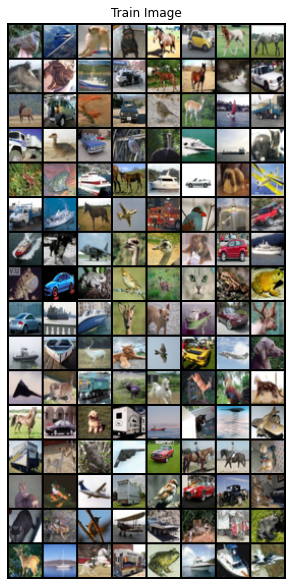

In [6]:
train_iter = iter(train_loader)
images, labels = train_iter.next()

imshow(images, "Train Image")

In [7]:
images.shape

torch.Size([128, 3, 32, 32])

## Train and Evaluate CNN

### Train CNN

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(64*5*5, 100),
            nn.ReLU(),
            nn.Linear(100, 10)              
        )
        
    def forward(self, x):
        out = self.conv_layer(x)
        out = out.view(-1, 64*5*5)
        out = self.fc_layer(out)
        
        return out
    
model = CNN().cuda()

In [9]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [10]:
num_epochs = 10

In [12]:
for epoch in range(num_epochs):

    total_batch = len(train_data) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.cuda()
        Y = batch_labels.cuda()

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

Epoch [1/10], lter [200/390], Loss: 2.3035
Epoch [2/10], lter [200/390], Loss: 2.0744
Epoch [3/10], lter [200/390], Loss: 2.0344
Epoch [4/10], lter [200/390], Loss: 1.8204
Epoch [5/10], lter [200/390], Loss: 1.8403
Epoch [6/10], lter [200/390], Loss: 1.6573
Epoch [7/10], lter [200/390], Loss: 1.6922
Epoch [8/10], lter [200/390], Loss: 1.5479
Epoch [9/10], lter [200/390], Loss: 1.5466
Epoch [10/10], lter [200/390], Loss: 1.3747


### Evalute Model

In [13]:
correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

Accuracy of test images: 47.890000 %


Predicted:    cat  ship  ship  ship  frog


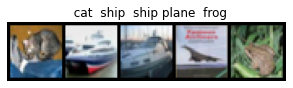

In [14]:
images, labels = iter(test_loader).next()
outputs = model(images.cuda())

_, predicted = torch.max(outputs.data, 1)
    
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(5)))

title = (' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(images, title)

## Train and Evaluate Developed CNN

### Preprocessing Data

In [15]:
transform = transforms.Compose([
    # Data Augmentation
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize(32),
    
    # Data Nomalization
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# Normalize a tensor image with mean and standard deviation.
# Given mean: (M1,...,Mn) and std: (S1,..,Sn) for n channels,
# this transform will normalize each channel of the input torch.
# *Tensor i.e. input[channel] = (input[channel] - mean[channel]) / std[channel]

train_data = dsets.CIFAR10(root='./data', 
                           train=True,
                           download=True, 
                           transform=transform)

test_data  = dsets.CIFAR10(root='./data', 
                           train=False,
                           download=True, 
                           transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
batch_size = 128

train_loader = DataLoader(train_data, 
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(test_data, 
                         batch_size=batch_size,
                         shuffle=False)

### Train CNN

In [3]:
import torch.nn.init as init

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, 5),
            nn.BatchNorm2d(32), # Batch Nomalization
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 5),
            nn.BatchNorm2d(64), # Batch Nomalization
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(64 * 5 * 5, 100),
            nn.ReLU(),
            nn.Dropout(0.1), # Dropout
            nn.Linear(100, 10)              
        )
        
        # Weight Initialization
        for m in self.modules() :
            if isinstance(m, nn.Conv2d):
                # init.xavier_normal(m.weight.data)
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)      
            if isinstance(m, nn.Linear):
                # init.xavier_normal(m.weight.data)
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)                
        
    def forward(self, x):
        out = self.conv_layer(x)
        out = out.view(-1, 64*5*5)
        out = self.fc_layer(out)
        
        return out
    
model = CNN().cuda()

### Custom Weight Initialization (Revisited)

In [5]:
model.conv_layer

Sequential(
  (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [7]:
model.conv_layer[0].weight

Parameter containing:
tensor([[[[ 0.0417,  0.1233,  0.2820, -0.1210, -0.1262],
          [-0.1399,  0.1211, -0.1580,  0.1936, -0.0168],
          [-0.1954, -0.1060,  0.0605,  0.1390, -0.2209],
          [ 0.1442, -0.0890,  0.1046, -0.0468,  0.0465],
          [-0.1223,  0.0301, -0.0817,  0.1120,  0.2229]],

         [[ 0.0103, -0.2411, -0.1337,  0.1717,  0.1104],
          [ 0.1363,  0.0807, -0.1359, -0.1462, -0.0040],
          [ 0.0271, -0.1645,  0.0822,  0.1222, -0.0600],
          [ 0.0506,  0.1590, -0.1369, -0.1400,  0.2132],
          [ 0.4096, -0.1213,  0.0643,  0.0639,  0.4031]],

         [[-0.0181,  0.1424, -0.3290, -0.1401, -0.1367],
          [ 0.0225, -0.1088,  0.1557,  0.0126,  0.1380],
          [ 0.1923, -0.3004,  0.2028, -0.1607,  0.2001],
          [-0.1846,  0.0950,  0.1233,  0.0857, -0.1834],
          [ 0.2689, -0.2721, -0.0343, -0.0890,  0.0267]]],


        [[[ 0.2609, -0.1258, -0.0099, -0.1993,  0.0275],
          [-0.1404, -0.1235,  0.2503,  0.2307,  0.1023],
 

In [9]:
model.conv_layer[0].weight.data = torch.ones_like(model.conv_layer[0].weight.data)

In [10]:
model.conv_layer[0].weight

Parameter containing:
tensor([[[[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]],

         [[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]],

         [[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]],

         [[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]],

         [[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]]],


  

### Training

In [28]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Momentum & Weight Regularization(L2)
# optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-5)

In [29]:
num_epochs = 10

In [30]:
for epoch in range(num_epochs):

    total_batch = len(train_data) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.cuda()
        Y = batch_labels.cuda()

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

Epoch [1/10], lter [200/390], Loss: 1.4359
Epoch [2/10], lter [200/390], Loss: 1.2479
Epoch [3/10], lter [200/390], Loss: 1.1283
Epoch [4/10], lter [200/390], Loss: 0.8798
Epoch [5/10], lter [200/390], Loss: 0.8523
Epoch [6/10], lter [200/390], Loss: 0.8114
Epoch [7/10], lter [200/390], Loss: 0.8994
Epoch [8/10], lter [200/390], Loss: 0.8058
Epoch [9/10], lter [200/390], Loss: 0.6106
Epoch [10/10], lter [200/390], Loss: 0.8458


### Warning: BatchNorm and Dropout

In [33]:
with torch.no_grad():
    for images, labels in test_loader:
        print("First Forward:", model(images[0:3].cuda()))
        print("Second Forward:", model(images[0:3].cuda()))
        print("Thrid Forward:", model(images[0:3].cuda()))
        break

First Forward: tensor([[-4.2463, -4.9541,  2.4658,  6.3601, -2.3128,  4.3417,  3.5289, -1.8067,
         -7.4792, -4.6670],
        [ 0.8018,  2.6871, -3.5744, -1.9662, -3.3673, -2.8671, -2.4251, -2.9908,
          1.4485,  1.8308],
        [ 2.0684, -0.1240,  0.4194, -0.8974, -2.0340, -1.9139, -2.0480,  0.3579,
         -0.1779,  0.1812]], device='cuda:0')
Second Forward: tensor([[-2.7006, -2.9218,  1.7624,  5.6074, -1.0917,  3.3985,  3.6522, -3.7877,
         -5.2645, -2.0645],
        [ 1.5983,  3.3493, -4.0797, -2.8367, -4.1604, -3.4641, -2.8751, -4.2978,
          1.9182,  2.4013],
        [ 1.0722, -0.5378,  0.5520, -0.5738, -1.8093, -1.5097, -1.8769,  0.5687,
         -0.0892, -0.4053]], device='cuda:0')
Thrid Forward: tensor([[-5.8766, -4.6685,  2.0985,  5.0125, -3.5682,  3.0131,  3.1156, -0.7491,
         -5.3013, -3.1618],
        [ 0.9578,  2.3160, -2.8216, -1.8264, -3.0802, -2.7492, -3.1438, -5.1936,
          2.1709,  2.4213],
        [ 1.9874, -1.3122,  0.6869, -0.4116, -

In [34]:
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        print("First Forward:", model(images[0:3].cuda()))
        print("Second Forward:", model(images[0:3].cuda()))
        print("Thrid Forward:", model(images[0:3].cuda()))
        break

First Forward: tensor([[-2.8330, -3.8474,  1.6850,  5.5905, -1.5347,  3.3621,  3.0485, -2.1605,
         -4.5229, -3.4946],
        [ 2.6084,  3.9178, -3.7887, -3.0477, -4.4872, -4.5338, -3.7251, -5.7774,
          3.5248,  2.2716],
        [ 0.6572,  1.1617, -2.2728, -1.5145, -1.6707, -2.1549, -1.1436, -0.0323,
          0.2958,  1.1258]], device='cuda:0')
Second Forward: tensor([[-2.8330, -3.8474,  1.6850,  5.5905, -1.5347,  3.3621,  3.0485, -2.1605,
         -4.5229, -3.4946],
        [ 2.6084,  3.9178, -3.7887, -3.0477, -4.4872, -4.5338, -3.7251, -5.7774,
          3.5248,  2.2716],
        [ 0.6572,  1.1617, -2.2728, -1.5145, -1.6707, -2.1549, -1.1436, -0.0323,
          0.2958,  1.1258]], device='cuda:0')
Thrid Forward: tensor([[-2.8330, -3.8474,  1.6850,  5.5905, -1.5347,  3.3621,  3.0485, -2.1605,
         -4.5229, -3.4946],
        [ 2.6084,  3.9178, -3.7887, -3.0477, -4.4872, -4.5338, -3.7251, -5.7774,
          3.5248,  2.2716],
        [ 0.6572,  1.1617, -2.2728, -1.5145, -

### Eval Developed CNN

In [35]:
# 이제부터는 꼭 해주어야함.
# Batch Norm과 Dropout은 Train과 Test일 때 서로 다르게 행동함.
model.eval()

# 반대로 다시 Train을 해야하면
# model.train()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:

        images = images.cuda()
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()

    print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

Accuracy of test images: 66.770000 %
